<a href="https://colab.research.google.com/github/seven320/air_pollutants/blob/main/FP002_sic_cos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Apr 17 13:02:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os, sys
COLAB = "google.colab" in sys.modules

if COLAB:
    from google.colab import drive
    from google.colab import output
    drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
if COLAB:
    !pip install transformers > /dev/null
    !pip install einops > /dev/null
    !pip install timm > /dev/null
    !pip install kaggle > /dev/null
    !pip install kaggle_datasets > /dev/null
    !pip install git+https://github.com/albumentations-team/albumentations
    !pip install tensorflow-determinism
    !pip install -q iterative-stratification
    output.clear()


    # for gpu
    !git clone --recursive https://github.com/Microsoft/LightGBM
    %cd /content/LightGBM/
    !mkdir build
    !cmake -DUSE_GPU=1 
    !make -j$(nproc)
    !sudo apt-get -y install python-pip

    !sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
    #pandasのエラーが出る場合は上記のコードからpandasを削除

    !sudo -H pip install setuptools numpy scipy scikit-learn -U
    %cd /content/LightGBM/python-package
    !sudo python setup.py install --precompile

Cloning into 'LightGBM'...
remote: Enumerating objects: 25705, done.
remote: Counting objects: 100% (25705/25705), done.
remote: Compressing objects: 100% (6039/6039), done.
remote: Total 25705 (delta 19078), reused 25159 (delta 18788), pack-reused 0
Receiving objects: 100% (25705/25705), 18.56 MiB | 17.86 MiB/s, done.
Resolving deltas: 100% (19078/19078), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21733, done.        
remote: Counting objects: 100% (5/5), done.        
re

In [4]:
import gc
import json
import math
import os
import random
import re
import time
import copy
import warnings
from requests import get
from contextlib import contextmanager
from typing import List, Optional, TypeVar, Type

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, train_test_split, KFold
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from einops.layers.torch import Rearrange, Reduce
import timm

from tqdm.notebook import tqdm
from transformers import AdamW, get_cosine_schedule_with_warmup
from typing import Optional, Tuple
from xgboost import XGBRegressor
import lightgbm as lgb

In [5]:
warnings.simplefilter('ignore')

In [6]:
if COLAB:    
    NOTEBOOK_NAME = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
    print(NOTEBOOK_NAME)

FP002-sic-cos


In [7]:
COMPE_NAME = "air_pollutants"
BASE_DIR = f"/content/drive/MyDrive/signate/{COMPE_NAME}"

# KAGGLE ONLY HAS 1, BUT OFFLINE, YOU CAN USE MORE
os.environ["CUDA_VISIBLE_DEVICES"]="0" #0,1,2,3 for four gpu

In [8]:
if COLAB:
    INPUT_DIR = Path(os.path.join(BASE_DIR ,f"input"))
    INPUT_DIR.mkdir(exist_ok=True, parents=True)

    SAVE_DIR = Path(os.path.join(BASE_DIR ,f"models/{NOTEBOOK_NAME}"))
    SAVE_DIR.mkdir(exist_ok=True, parents=True)

    OOF_DIR = Path(os.path.join(BASE_DIR, f"oof/{NOTEBOOK_NAME}"))
    OOF_DIR.mkdir(exist_ok=True, parents = True)

    SUB_DIR = Path(os.path.join(BASE_DIR, f"submission/{NOTEBOOK_NAME}"))
    SUB_DIR.mkdir(exist_ok=True, parents = True)

In [47]:
train_df = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT_DIR, "test.csv"))
sample_df = pd.read_csv(os.path.join(INPUT_DIR, "submit_sample.csv"), names=["id", "predict"])

print(train_df.shape, test_df.shape, sample_df.shape)

(195941, 54) (53509, 53) (53509, 2)


In [10]:
# Config
NUM_FOLDS = 10

In [11]:
#############
## Utility ##
#############
@contextmanager
def timer(name: str):
    t0 = time.time()
    print(f"[{name}] start")
    yield
    print(f"[{name}] done - elapsed {time.time() - t0:.2f}s")

In [12]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [13]:
train_df.head()

,id,year,month,day,Country,City,lat,lon,co_cnt,co_min,...,ws_min,ws_mid,ws_max,ws_var,dew_cnt,dew_min,dew_mid,dew_max,dew_var,pm25_mid
0,1,2019,1,1,Australia,Brisbane,-27.46794,153.02809,38,0.749,...,0.241,1.088,3.101,1.983,17,7.671,10.358,15.112,13.424,19.901
1,2,2019,1,1,Australia,Darwin,-12.46113,130.84185,47,2.594,...,0.828,3.473,7.396,10.411,62,21.324,23.813,24.221,2.021,13.741
2,3,2019,1,1,Australia,Melbourne,-37.81400,144.96332,17,1.190,...,0.000,2.107,8.089,15.719,22,10.309,13.133,15.422,6.355,25.918
3,4,2019,1,1,Australia,Newcastle,-32.92953,151.78010,63,4.586,...,0.284,0.503,3.592,2.485,116,7.146,10.685,13.344,9.417,174.370
4,5,2019,1,1,Australia,Perth,-31.95224,115.86140,47,4.689,...,0.500,0.755,3.396,1.937,93,1.091,3.277,12.272,4.109,167.063


In [57]:
train_city = train_df["City"].unique().tolist()
test_city = test_df["City"].unique().tolist()

train_city_cnt = len(train_city)
test_city_cnt = len(test_city)

print(f"train city count: {train_city_cnt}")
print(f"test city count: {test_city_cnt}")

print(f"{len(set(train_city) & set(test_city))}")

train city count: 239
test city count: 63
0


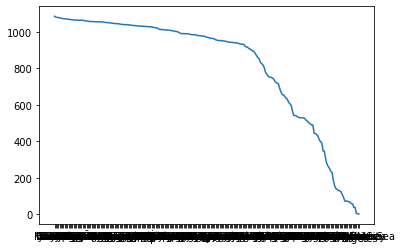

In [58]:
plt.plot(train_df["City"].value_counts())

In [59]:
kf = GroupKFold(n_splits = NUM_FOLDS)

folds = copy.deepcopy(train_df[["id"]])
folds["kfold"] = -1

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df, train_df["pm25_mid"], train_df["City"])):
    print(f"train_idx: {len(train_idx)}, valid_idx: {len(valid_idx)}")
    folds.loc[valid_idx, "kfold"] = fold

train_df = train_df.merge(folds[["id", "kfold"]], on="id", how="left")

train_idx: 176357, valid_idx: 19584
train_idx: 176333, valid_idx: 19608
train_idx: 176339, valid_idx: 19602
train_idx: 176363, valid_idx: 19578
train_idx: 176358, valid_idx: 19583
train_idx: 176336, valid_idx: 19605
train_idx: 176334, valid_idx: 19607
train_idx: 176334, valid_idx: 19607
train_idx: 176361, valid_idx: 19580
train_idx: 176354, valid_idx: 19587


# Train

In [60]:
import logging
from typing import List, Optional, TypeVar

import pandas as pd

class AbstractFeatureTransformer:
    def __init__(self):
        self.name = self.__class__.__name__

    def fit_transform(self, input_df: pd.DataFrame, y=None):
        self.fit(input_df, y)
        return self.transform(input_df)

    def fit(self, input_df: pd.DataFrame, y=None):
        pass

    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        raise NotImplementedError

Transformer = TypeVar("Transformer", bound=AbstractFeatureTransformer)

def extract_features(input_df: pd.DataFrame,
                     transformers: List[Transformer],
                     fit: bool = True,
                     logger: Optional[logging.Logger] = None):
    feature_dfs = []
    for transformer in transformers:
        # timerはブロックの実行時間を計測するユーティリティ
        with timer(f"Extract features with {transformer.name}", logger):
            if fit:
                feature_dfs.append(transformer.fit_transform(input_df))
            else:
                feature_dfs.append(transformer.transform(input_df))
    all_features = pd.concat(feature_dfs, axis=1)
    return all_features

In [61]:
class Numericals(AbstractFeatureTransformer):
    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        cols = [pd.api.types.is_numeric_dtype(dtype) for dtype in input_df.dtypes]
        return input_df.loc[:, cols]

class LabelEncoding(AbstractFeatureTransformer):
    def __init__(self, columns: List[str]):
        super().__init__()
        self.le_columns = columns
        self.encoders = {
            column: LabelEncoder()
            for column in self.le_columns
        }
        self.__is_fitted = False

    def fit(self, input_df: pd.DataFrame, y: Optional[np.ndarray] = None):
        """
        ラベルに変換する前に欠損値を埋める
        """
        for column in self.le_columns:
            self.encoders[column].fit(input_df[column].fillna(""))
        self.__is_fitted = True

    def transform(
        self, 
        input_df: pd.DataFrame, 
        y: Optional[np.ndarray] = None
    ) -> pd.DataFrame:
        assert self.__is_fitted, "You need to call `fit` first."
        encoded = {}
        for column in self.le_columns:
            encoded[column] = self.encoders[column].transform(
                input_df[column].fillna(""))
        return pd.DataFrame(encoded)

In [62]:
def preprocess(df:pd.DataFrame)->pd.DataFrame:
    # 経度をcosに変換
    df["lon_cos"] = np.cos(np.radians((df["lon"] + 180)))

    df["month_cos"] = np.cos(np.radians(df["month"] / 12 * 360))
    df["month_sin"] = np.sin(np.radians(df["month"] / 12 * 360))
    
    return df

In [63]:
train_df = preprocess(train_df)
test_df = preprocess(test_df)

In [64]:
train_df.head()

,id,year,month,day,Country,City,lat,lon,co_cnt,co_min,...,dew_cnt,dew_min,dew_mid,dew_max,dew_var,pm25_mid,lon_cos,month_cos,month_sin,kfold
0,1,2019,1,1,Australia,Brisbane,-27.46794,153.02809,38,0.749,...,17,7.671,10.358,15.112,13.424,19.901,0.891229,0.866025,0.5,8
1,2,2019,1,1,Australia,Darwin,-12.46113,130.84185,47,2.594,...,62,21.324,23.813,24.221,2.021,13.741,0.653973,0.866025,0.5,0
2,3,2019,1,1,Australia,Melbourne,-37.81400,144.96332,17,1.190,...,22,10.309,13.133,15.422,6.355,25.918,0.818785,0.866025,0.5,1
3,4,2019,1,1,Australia,Newcastle,-32.92953,151.78010,63,4.586,...,116,7.146,10.685,13.344,9.417,174.370,0.881139,0.866025,0.5,6
4,5,2019,1,1,Australia,Perth,-31.95224,115.86140,47,4.689,...,93,1.091,3.277,12.272,4.109,167.063,0.436196,0.866025,0.5,0


In [65]:
# numericals = Numericals()
# 数字に関する変換
# train_df_num = numericals.transform(train_df)

# ラベルに関する変換
# labelencoding = LabelEncoding(columns = [])

# labelencoding.fit(train_df_num)
# train_df_labeled = labelencoding.transform(train_df_num)

In [66]:
class AbstractTreeModel:
    def __init__(self, prediction_type="regression"):
        self.model = None
        self.prediction_type = prediction_type

    def train(self,
              params: dict,
              X_train: pd.DataFrame,
              y_train: np.ndarray,
              X_val: pd.DataFrame,
              y_val: np.ndarray,
              train_weights: Optional[np.ndarray] = None,
              val_weights: Optional[np.ndarray] = None,
              train_params: Optional[dict] = None):
        if train_params is None:
            train_params = {}

        model = self._train(
            params,
            X_train, y_train,
            X_val, y_val,
            train_weights, val_weights,
            train_params)
        self.model = model
        return self

    def _train(self,
               params,
               X_train,
               y_train,
               X_val,
               y_val,
               train_weights,
               val_weights,
               train_params):
        raise NotImplementedError

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        raise NotImplementedError

    @property
    def feature_names_(self):
        raise NotImplementedError

    @property
    def feature_importances_(self):
        raise NotImplementedError

    def _check_if_trained(self):
        assert self.model is not None, "You need to train the model first"


class LGBModel(AbstractTreeModel):
    def _train(self,
               params,
               X_train, y_train,
               X_val, y_val,
               train_weights, val_weights,
               train_params):
        trn_data = lgb.Dataset(X_train, y_train, weight=train_weights)
        val_data = lgb.Dataset(X_val, y_val, weight=val_weights)
        model = lgb.train(params=params,
                          train_set=trn_data,
                          valid_sets=[trn_data, val_data],
                          **train_params)
        return model

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        self._check_if_trained()
        return self.model.predict(X, num_iteration=self.model.best_iteration)

    @property
    def feature_names_(self):
        self._check_if_trained()
        return self.model.feature_name()

    @property
    def feature_importances_(self):
        self._check_if_trained()
        return self.model.feature_importance(importance_type="gain")


def get_tree_model(name: str) -> Type[AbstractTreeModel]:
    DEFINED_MODELS = {
        "lgb": LGBModel,
        # 実装していない
        # "xgb": XGBModel,
        # "cat": CatBoostModel
    }
    model = DEFINED_MODELS.get(name)
    if model is None:
        raise ValueError(
            """Invalid model name: {}.
            Pre-defined model names are as follows: {}""".format(
                name,
                ",".join(DEFINED_MODELS.keys())
            ))
    return model

In [67]:
def show_feature_importance(model: AbstractTreeModel):
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, model.feature_names_)), columns=['Value','Feature'])
    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
    # plt.savefig('lgbm_importances-01.png')

In [71]:
parameters = {
            'objective': 'rmse',
            'metric': 'rmse',
            'max_bin': 255,
            'n_estimators':5000,
            'learning_rate': 0.03,
            'max_depth': 16,
            'num_leaves': 8,
            'early_stopping_rounds': 100,
            "device": "gpu",  
}

In [72]:
lgb_model = get_tree_model("lgb")()

cat_cols = [c for c in train_df.columns if train_df[c].dtype == np.object]

num_cols = [c for c in train_df.columns if train_df[c].dtype != np.object]
if "id" in num_cols:
    num_cols.remove("id")
if "kfold" in num_cols:
    num_cols.remove("kfold")
num_cols.remove("pm25_mid")

target_cols = "pm25_mid"

In [73]:
lgb_models = []

oof_df = train_df[["id"]]
oof_df["oof"] = -1

for i in range(NUM_FOLDS):
    train_data = train_df[train_df["kfold"] != i].reset_index(drop = True)
    valid_data = train_df[train_df["kfold"] == i].reset_index(drop = True)

    print(f"train_data nums: {len(train_data)}, valid_data nums: {len(valid_data)}")

    lgb_model.train(
        params = parameters,
        X_train = train_data[num_cols],
        y_train = train_data[target_cols],
        X_val = valid_data[num_cols],
        y_val = valid_data[target_cols],
    )
    lgb_models.append(lgb_model)

    oof = lgb_model.predict(
        valid_data[num_cols]
    )
    oof_df.loc[train_df["kfold"] == i, "oof"] = oof
train_oof = train_df.merge(oof_df[["id", "oof"]], on = "id", how = "left")

train_data nums: 176357, valid_data nums: 19584
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12184
[LightGBM] [Info] Number of data points in the train set: 176357, number of used features: 53
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 53 dense feature groups (9.42 MB) transferred to GPU in 0.012310 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 59.202180
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2938]	training's rmse: 19.1979	valid_1's rmse: 21.9354
train_data nums: 176333, valid_data nums: 19608
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 12185
[LightGBM] [Info] Number of data points in the train set: 176333, number of used features: 53
[LightGBM]

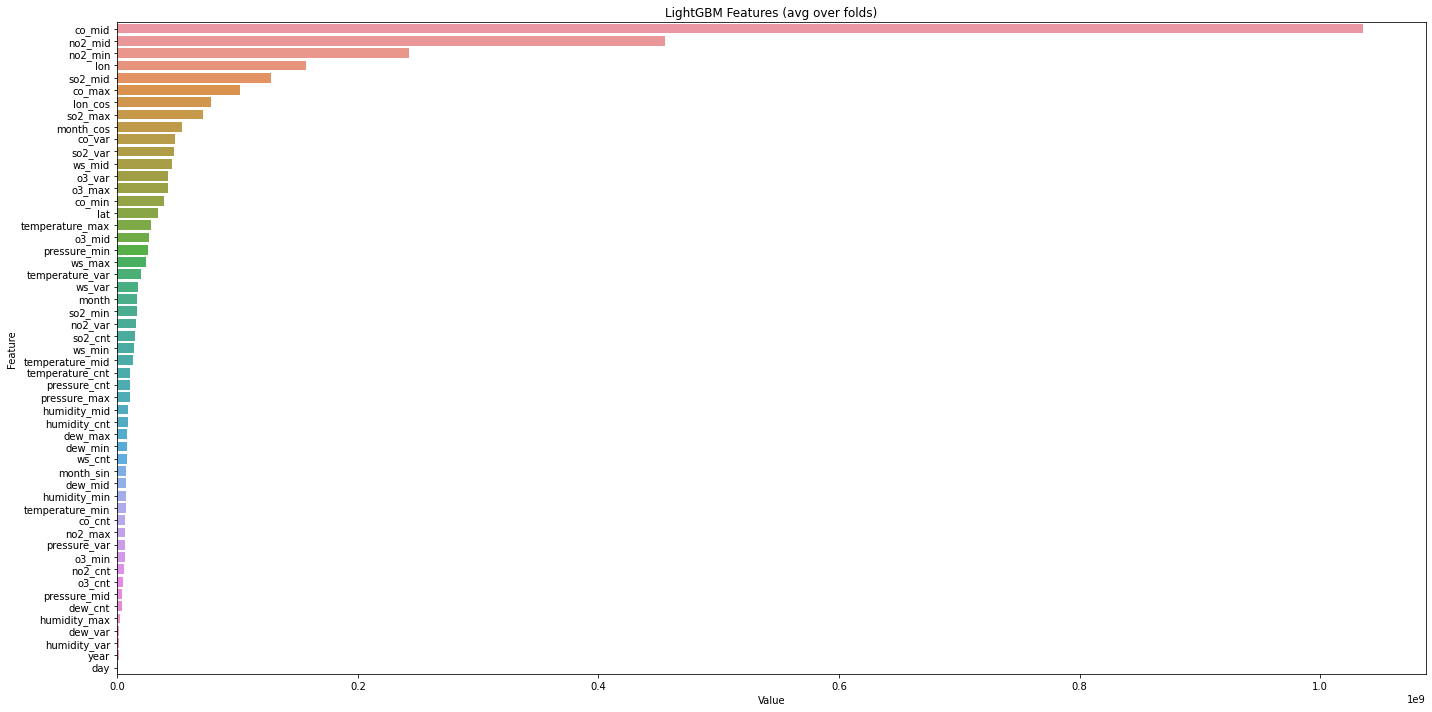

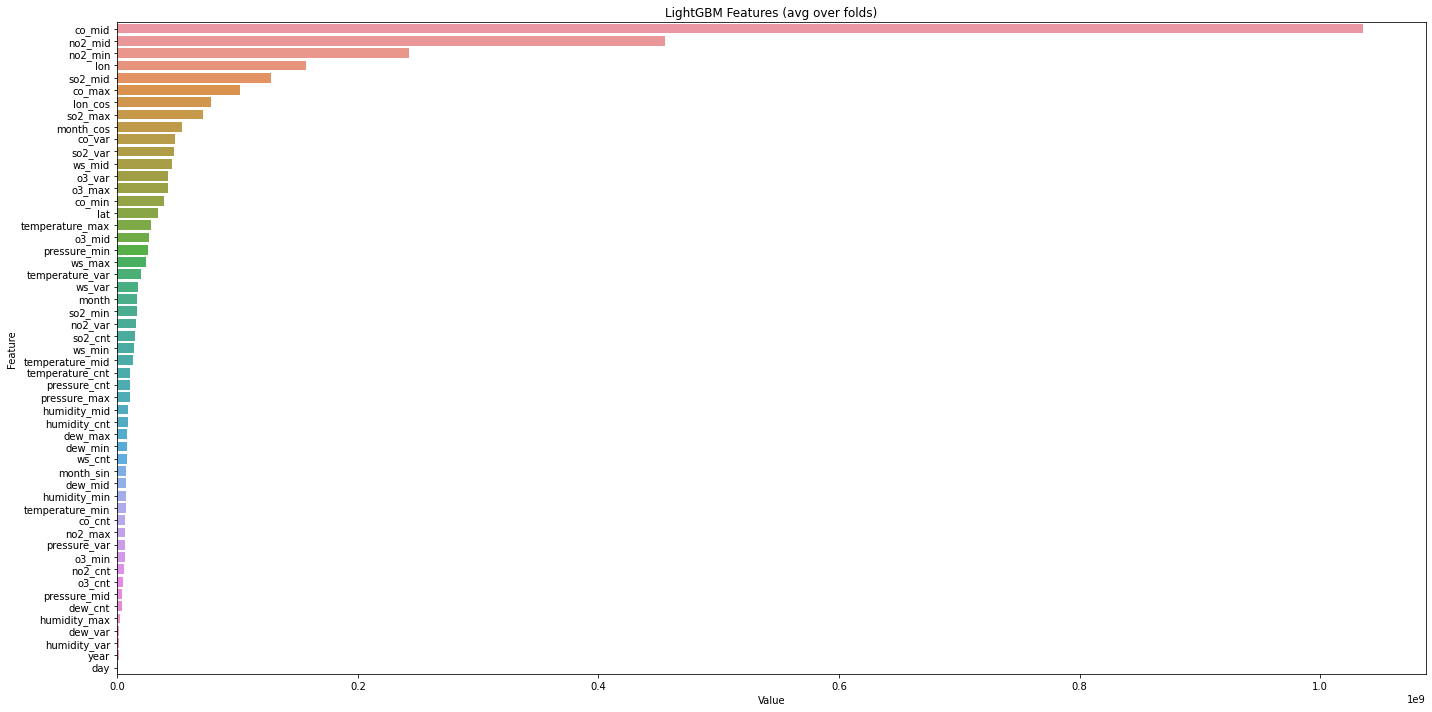

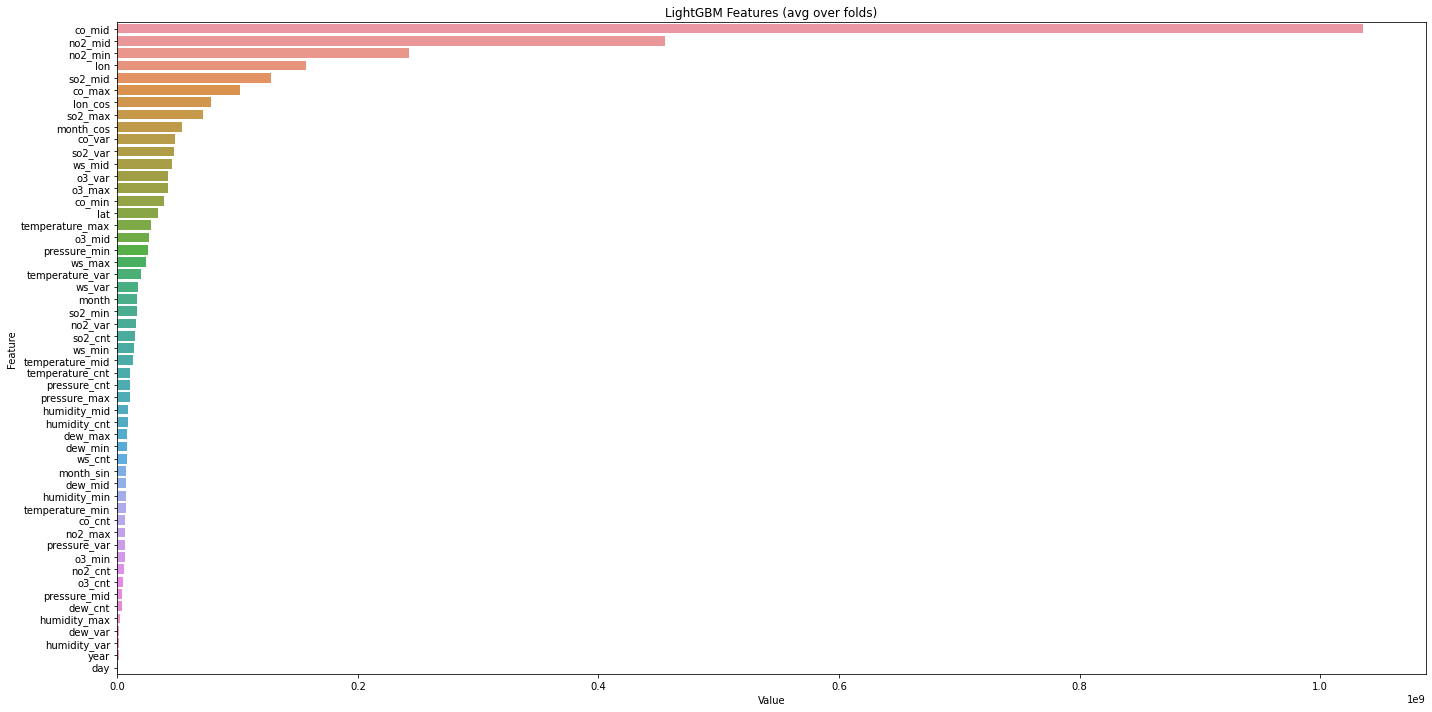

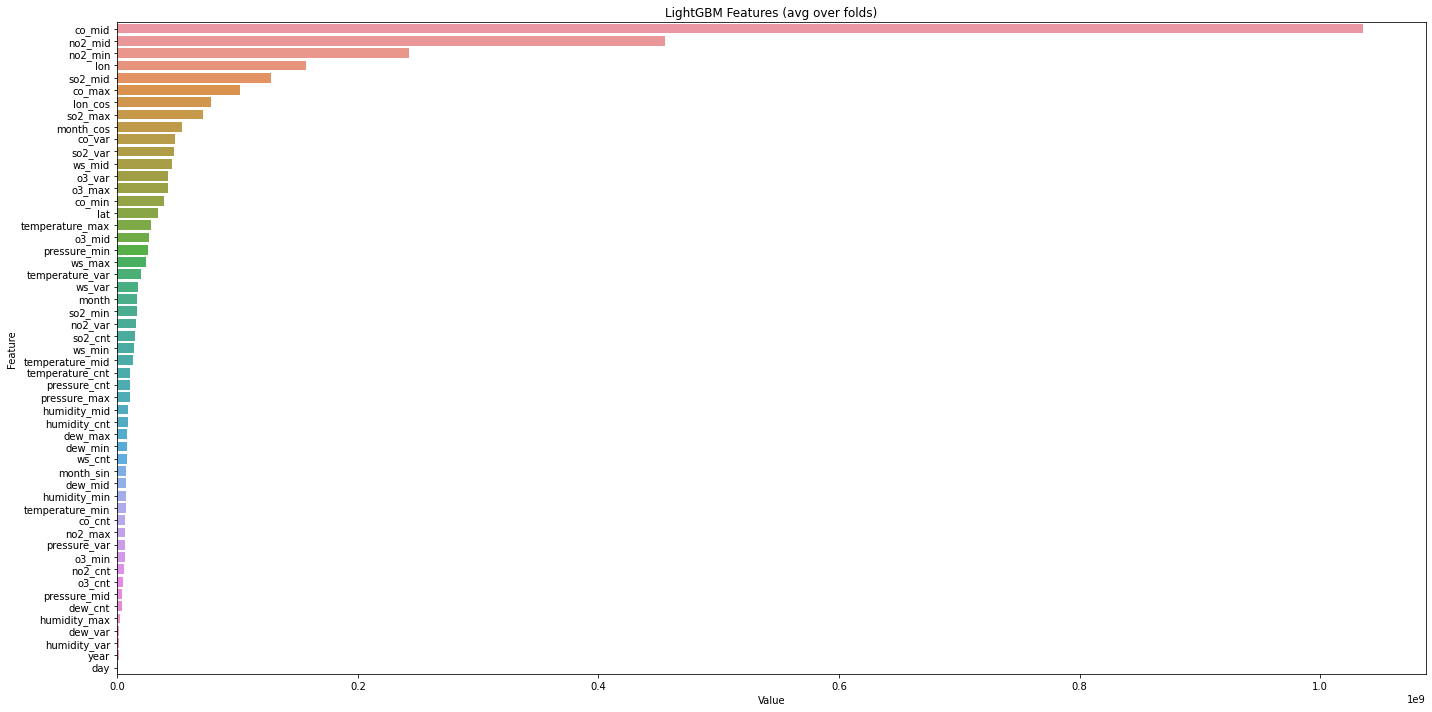

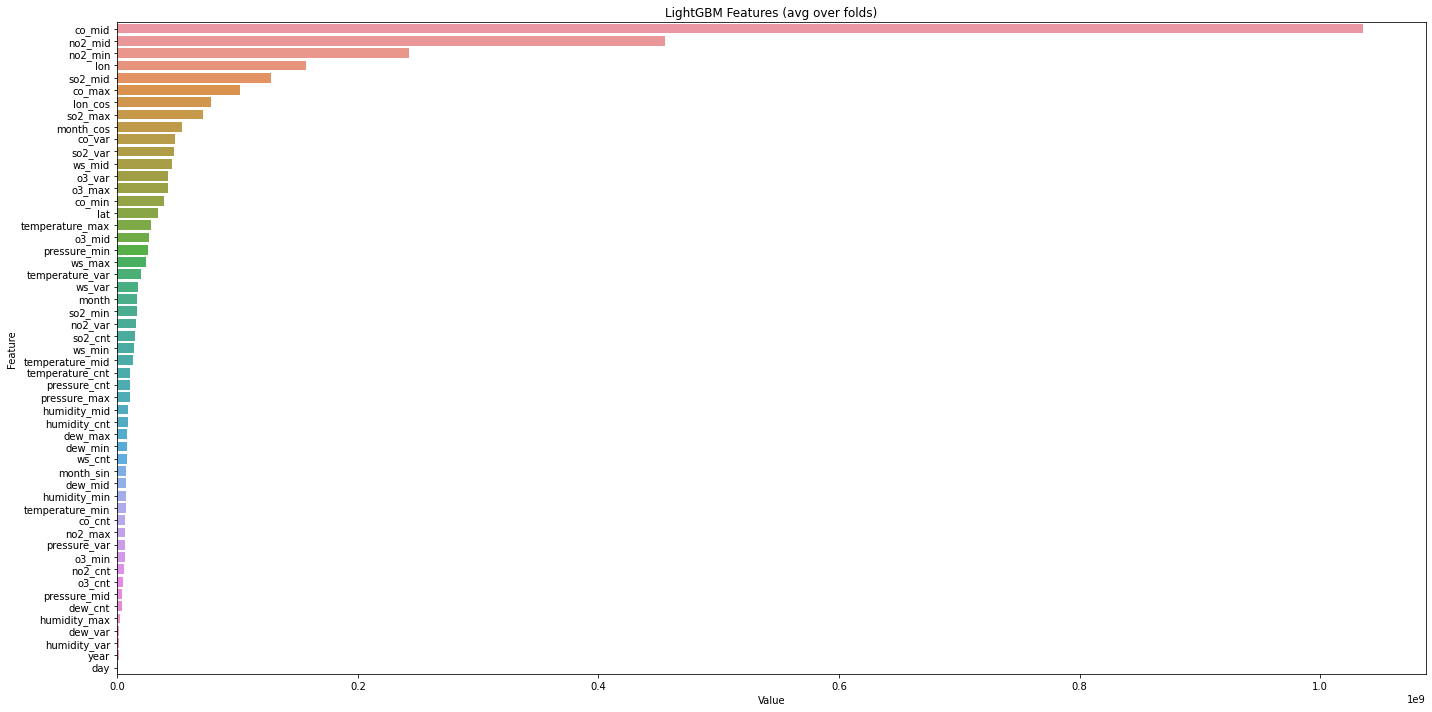

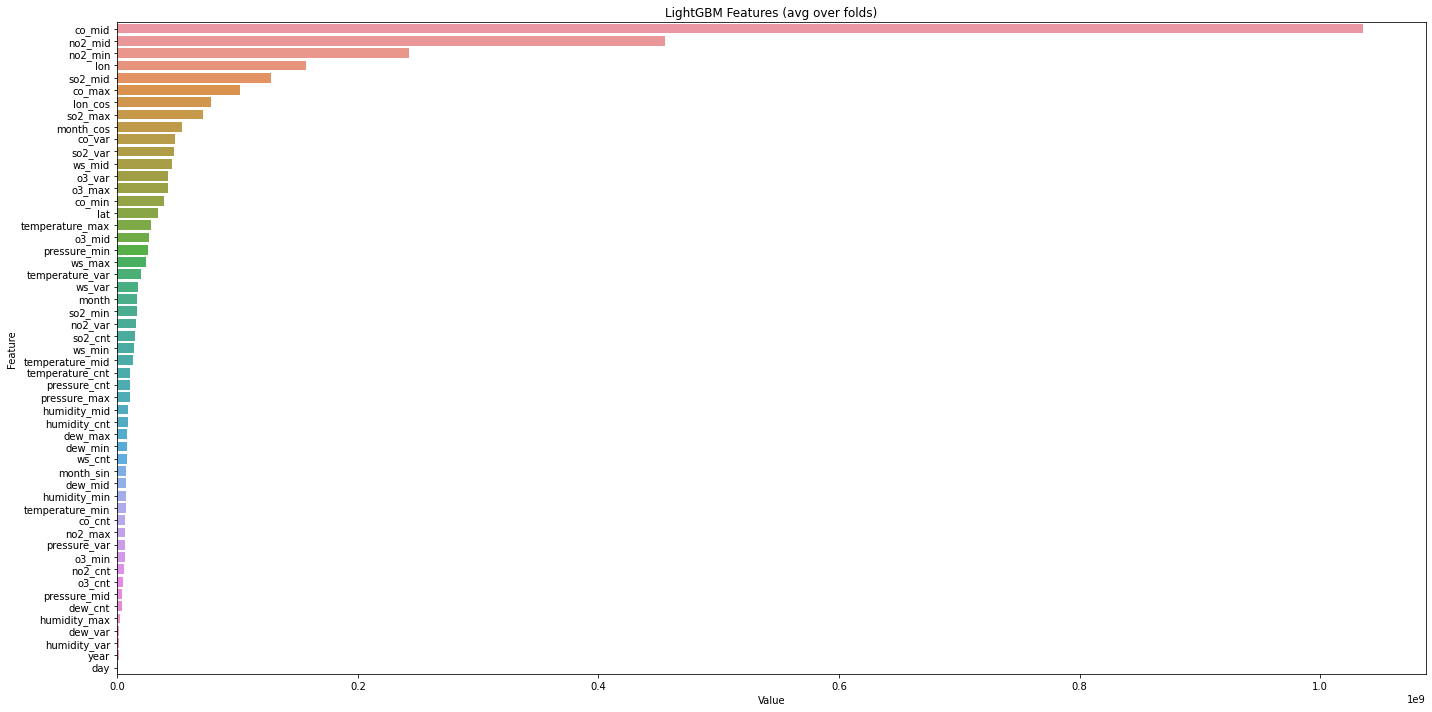

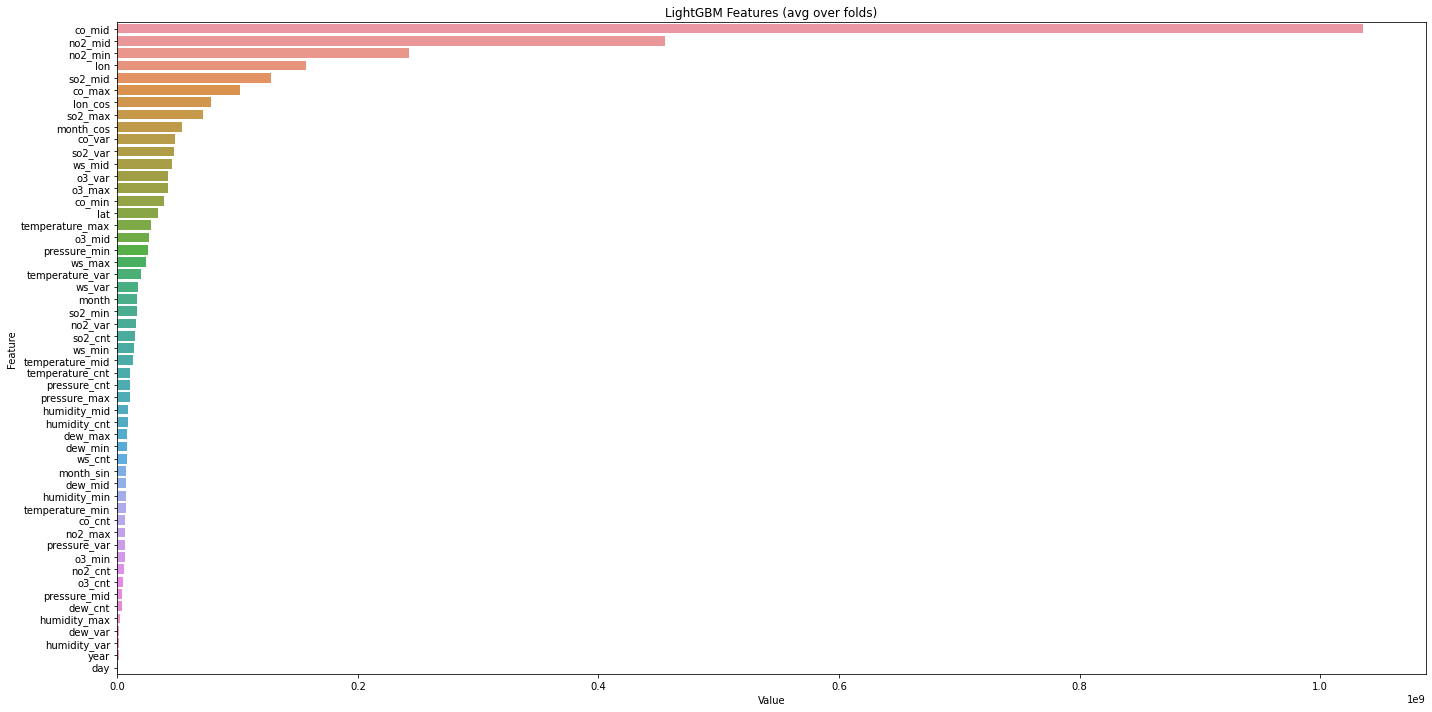

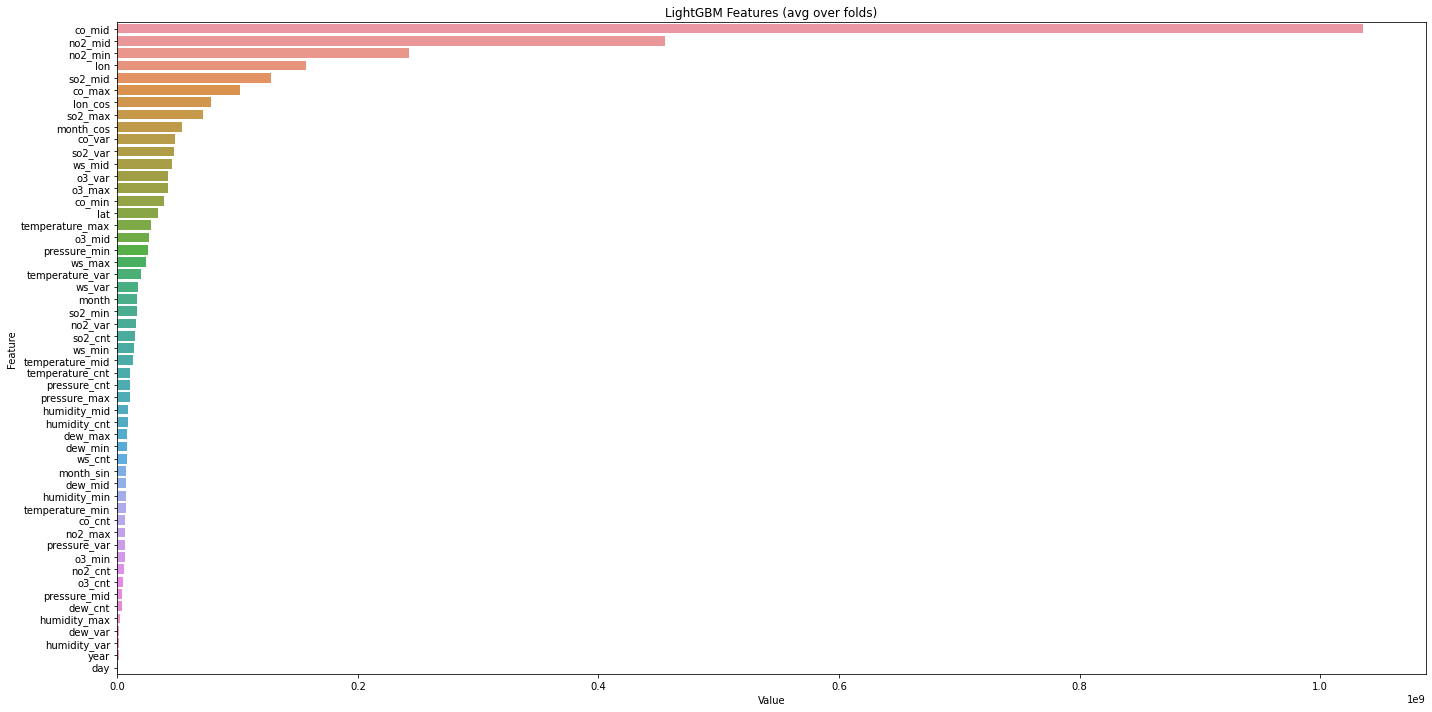

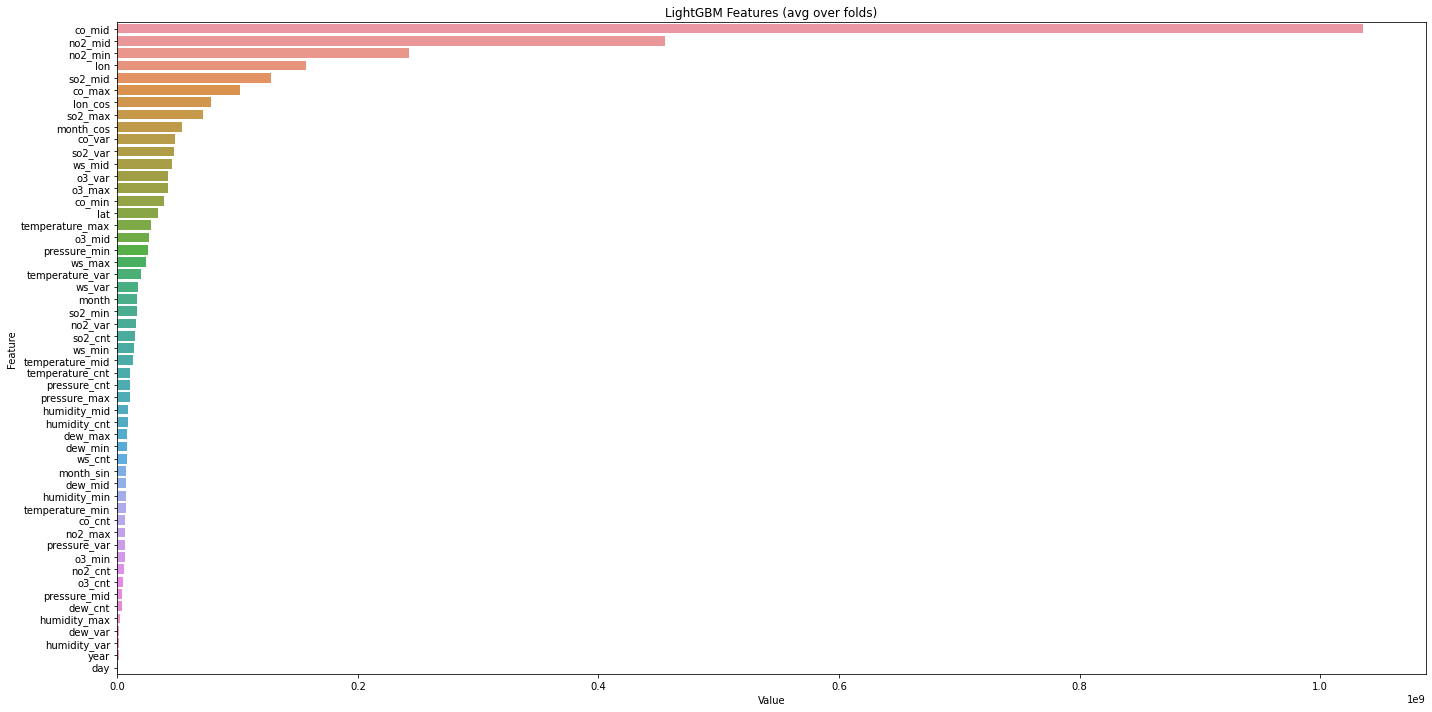

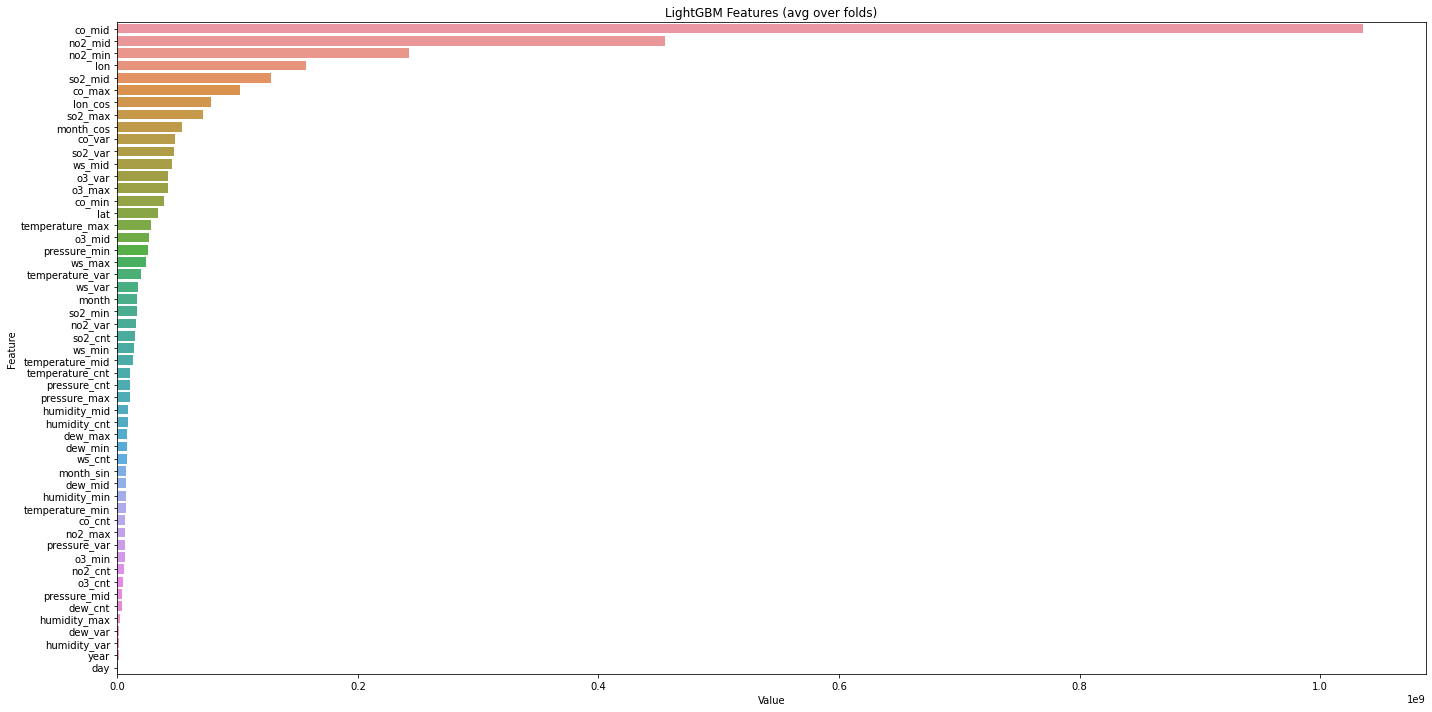

In [74]:
for lgb_model in lgb_models:
    show_feature_importance(lgb_model)

In [75]:
oof_score = np.sqrt(mean_squared_error(train_oof["pm25_mid"], train_oof["oof"]))
print(f"oof score: {oof_score}")

# 22.6422

oof score: 22.32247033516169


In [76]:
train_oof[["id","pm25_mid", "kfold", "oof"]].to_csv(os.path.join(OOF_DIR, "oof.csv"), index= False)

# predict

In [77]:
num_cols

['year',
 'month',
 'day',
 'lat',
 'lon',
 'co_cnt',
 'co_min',
 'co_mid',
 'co_max',
 'co_var',
 'o3_cnt',
 'o3_min',
 'o3_mid',
 'o3_max',
 'o3_var',
 'so2_cnt',
 'so2_min',
 'so2_mid',
 'so2_max',
 'so2_var',
 'no2_cnt',
 'no2_min',
 'no2_mid',
 'no2_max',
 'no2_var',
 'temperature_cnt',
 'temperature_min',
 'temperature_mid',
 'temperature_max',
 'temperature_var',
 'humidity_cnt',
 'humidity_min',
 'humidity_mid',
 'humidity_max',
 'humidity_var',
 'pressure_cnt',
 'pressure_min',
 'pressure_mid',
 'pressure_max',
 'pressure_var',
 'ws_cnt',
 'ws_min',
 'ws_mid',
 'ws_max',
 'ws_var',
 'dew_cnt',
 'dew_min',
 'dew_mid',
 'dew_max',
 'dew_var',
 'lon_cos',
 'month_cos',
 'month_sin']

In [78]:
sum_predict = None
for lgb_model in lgb_models:
    predict = lgb_model.predict(
        test_df[num_cols],
    )
    if sum_predict is None:
        sum_predict = predict
    else:
        sum_predict += predict

mean_predict = sum_predict / len(lgb_models)

In [79]:
print(len(mean_predict))
print(sample_df.shape)
print(test_df.shape)

53509
(53509, 2)
(53509, 56)


In [80]:
sample_df.loc[:,"predict"] = mean_predict

In [81]:
sample_df.head()

,id,predict
0,195942,19.700023
1,195943,40.408848
2,195944,25.262600
3,195945,68.733178
4,195946,131.808343


In [82]:
sample_df.to_csv(os.path.join(SUB_DIR, "submission.csv"), index= False, header = False)

# submit

In [83]:
!pip install signate > /dev/null
!mkdir /root/.signate
!cp /content/drive/MyDrive/signate/signate.json /root/.signate/signate.json

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [84]:
submission_file = os.path.join(SUB_DIR, "submission.csv")

In [88]:
comment = f"cv{oof_score}_mean_10folds"
comment

'cv22.32247033516169_mean_10folds'

In [86]:
!signate submit --competition-id=624 {submission_file} --note {comment}

You have successfully submitted your predictions.We will send you the submission result to your email address.
